In [1]:
# load packages
import pandas as pd
import numpy as np

import ixmp                    # package for ix modeling platform
import message_ix              # package for MESSAGEix model
from message_ix.utils import make_df


from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

import matplotlib.pyplot as plt

import pyam

<IPython.core.display.Javascript object>

In [2]:
# Loading the platform (and getting conected to a local database)
mp = ixmp.Platform()

In [3]:
# create empty scenario
baseline = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario='baseline', version='new')

In [4]:
# read South Africa model from Excel (init_items = True is important as this scenario also includes MACRO)
baseline.read_excel("../resources/MESSAGEix_South_Africa.xlsx", add_units=True, commit_steps=False, init_items=True)

In [5]:
# solve baseline scenario
baseline.solve()

In [6]:
# check objective function value
baseline.var('OBJ')

{'lvl': 63014.5703125, 'mrg': 0.0}

In [7]:
# check emissions
baseline.var('EMISS').tail(12)

,node,emission,type_tec,year,lvl,mrg
12,South Africa,CO2,all,2020,514.450798,0.0
13,South Africa,CO2,all,2030,648.868289,0.0
14,South Africa,CO2,all,2040,733.833429,0.0
15,South Africa,CO2,all,2050,866.594934,0.0
16,South Africa,CO2,all,2060,1028.482914,0.0
17,South Africa,CO2,all,2070,1256.080006,0.0
18,South Africa,CH4,all,2020,13.374521,0.0
19,South Africa,CH4,all,2030,15.464832,0.0
20,South Africa,CH4,all,2040,16.595169,0.0
21,South Africa,CH4,all,2050,19.105427,0.0


# Adjustments to South Africa scenario

In [8]:
# The SSP scenario I follow
SSP = 'SSP2_v9_130219'

In [9]:
df = pd.read_csv('SspDb_country_data_2013-06-12.csv')

In [10]:
GDP_all_SSPs = df.loc[df.REGION == 'ZAF'].loc[df.VARIABLE == 'GDP|PPP'].loc[df.MODEL == 'IIASA GDP'].dropna(axis = 1)

In [11]:
# South Africa GDP in billion (2005) USD / year
SA_GDP = GDP_all_SSPs.loc[GDP_all_SSPs.SCENARIO == SSP].iloc[0,5:]
SA_GDP = SA_GDP.iloc[::2][:7]
SA_GDP

2010     372.179283
2020     543.236663
2030     764.394783
2040    1074.728452
2050    1412.498506
2060    1740.989661
2070    2047.090039
Name: 38319, dtype: object

<AxesSubplot:title={'center':'South Africa GDP in billion USD'}>

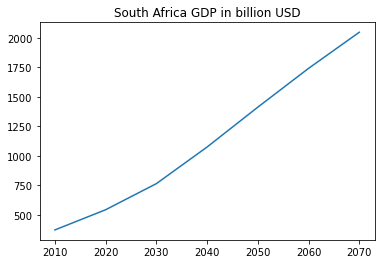

In [12]:
SA_GDP.plot(title='South Africa GDP in billion USD')

## Cement demand

The demand is based on GDP and may therefore at some point be based on endogenous GDP rather than the inputs given here. But for now the GDP will be exogeneous to make sure something weird does not happen with the GDP which will make it more difficult to troubleshoot.

In [13]:
Years = [2010, 2020, 2030, 2040, 2050, 2060, 2070]

In [14]:
SA_pop = np.array([51216967, 59308690, 65956090, 71375306, 75517909, 78172048, 79498839])   # https://www.populationpyramid.net/south-africa/2060/

In [15]:
GDPperpop = (SA_GDP*1e9/SA_pop).astype('float64')

<AxesSubplot:title={'center':'South Africa GDP per capita profile'}>

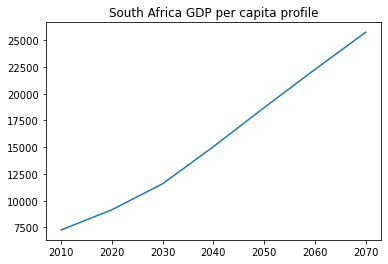

In [16]:
# GDP for South Africa for each year - exogeneous.
GDPperpop.plot(title='South Africa GDP per capita profile')

In [17]:
# cement demand in kg/yr
# Capita consumption: C = a*e^(b/GDPpc)
a = 487
b = -3047
cement_d = (a*np.exp(b/GDPperpop))*SA_pop

In [18]:
cement_d/1e6 #shown here in kt/y as reality check. Fits well with real data (e.g. Germany was 25583 kt a few years back)

2010    16399.826796
2020    20709.733702
2030    24694.647655
2040    28391.851576
2050    31248.571958
2060    33201.925249
2070    34395.332499
Name: 38319, dtype: float64

In [19]:
cement_d_Mt = cement_d/1e9 # cement demand in Mega tonnes per year

In [20]:
mp.add_unit('Mt/year')

In [21]:
# Add demand for cement in South Africa for the years 2010-2070
cement_demand = pd.DataFrame({
        'node': 'South Africa',
        'commodity': 'cement',
        'level': 'useful',
        'year': Years,
        'time': 'year',
        'value': cement_d_Mt, # Demand for cement in South Africa (Mt/year)
        'unit': 'Mt/year', # 'GWa/a'
    })

## Scenario setup

In [22]:
baseline_for_copy = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario='cement', version='new')

In [23]:
# read South Africa model from Excel (init_items = True is important as this scenario also includes MACRO)
baseline_for_copy.read_excel("../resources/MESSAGEix_South_Africa.xlsx", add_units=True, commit_steps=False, init_items=True)

In [24]:
# clone baseline scenario for modification
scenario_pc = baseline_for_copy.clone('MESSAGEix South Africa', 'cement added','copy of the baseline scenario with added emission constraint',
                  keep_solution=False)

In [25]:
# check out scenario for editing
scenario_pc.check_out()

In [26]:
# Using: scenario.add_par()     https://docs.messageix.org/en/stable/model/MESSAGE/parameter_def.html
# Add commodities and technologies relevant for portland cement production
scenario_pc.add_set("commodity", ['cement', 'limestone', 'clinker', 'pre-clinker', 'clinker_fuel'])
scenario_pc.add_set("technology", ['Resource_mine', 'Mining_clinker', 'Clinker_burning', 'Cement_grinding',
                               'clinker_lightoil', 'clinker_gas', 'clinker_fueloil', 'clinker_coal',  # Fuel-clinkerfuel transformers
                                  'Clinker_burning_CCS', 'Clinker_burning_opt_kiln']) # Emerging technologies

In [27]:
scenario_pc.add_par("demand", cement_demand) # The cement_demand is calcualted above in Mt/year

## Inputs and outputs (activities between technologies)

In [28]:
country = 'South Africa'

In [29]:
# Base dataframe for input and output adding node, years, mode, time, and unit
year_df = scenario_pc.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'M1',
    'time': 'year',
    'unit': '-'
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

An output of resources has to come from somewhere, I make the technology "Resource_mine" for this purpose

In [30]:
resource_mine_limestone = make_df(base_output, technology='Resource_mine', commodity='limestone', 
                   level='secondary', value=1.0)
scenario_pc.add_par('output', resource_mine_limestone)

### Mass flows

A clinker/cement coefficient (cc_c) describes how much clinker goes into cement.

The coefficient is based on: "global clinker-to-cement ratio of 78% in 2006" https://lowcarboneconomy.cembureau.eu/5-parallel-routes/resource-efficiency/clinker-substitution/

In [31]:
cc_c = 0.8
preclinker_to_clinker = 0.8
limestone_to_preclinker = 1/0.9

In [32]:
# Cement grinding
cement_grinding_out = make_df(base_output, technology='Cement_grinding', commodity='cement', 
                   level='useful', value=1.0)
scenario_pc.add_par('output', cement_grinding_out)

cement_grinding_in = make_df(base_input, technology='Cement_grinding', commodity='clinker',  
                  level='secondary', value=cc_c)
scenario_pc.add_par('input', cement_grinding_in)

In [33]:
# Clinker burning
clinker_burning_out = make_df(base_output, technology='Clinker_burning', commodity='clinker', 
                   level='secondary', value=1.0)
scenario_pc.add_par('output', clinker_burning_out)

clinker_burning_in = make_df(base_input, technology='Clinker_burning', commodity='pre-clinker',  
                  level='secondary', value=preclinker_to_clinker)
scenario_pc.add_par('input', clinker_burning_in)

In [34]:
# Mining clinker
mining_clinker_out = make_df(base_output, technology='Mining_clinker', commodity='pre-clinker', 
                   level='secondary', value=1.0)
scenario_pc.add_par('output', mining_clinker_out)

mining_clinker_in = make_df(base_input, technology='Mining_clinker', commodity='limestone',  
                  level='secondary', value=limestone_to_preclinker)
scenario_pc.add_par('input', mining_clinker_in)

##### Substituting technologies:

In [35]:
# Clinker_burning_CCS
clinker_burning_CCS_out = make_df(base_output, technology='Clinker_burning_CCS', commodity='clinker', 
                   level='secondary', value=1.0)
scenario_pc.add_par('output', clinker_burning_CCS_out)

clinker_burning_CCS_in = make_df(base_input, technology='Clinker_burning_CCS', commodity='pre-clinker',  
                  level='secondary', value=preclinker_to_clinker)
scenario_pc.add_par('input', clinker_burning_CCS_in)

In [36]:
# Clinker_burning_opt_kiln
clinker_burning_opt_kiln_out = make_df(base_output, technology='Clinker_burning_opt_kiln', commodity='clinker', 
                   level='secondary', value=1.0)
scenario_pc.add_par('output', clinker_burning_opt_kiln_out)

clinker_burning_opt_kiln_in = make_df(base_input, technology='Clinker_burning_opt_kiln', commodity='pre-clinker',  
                  level='secondary', value=preclinker_to_clinker)
scenario_pc.add_par('input', clinker_burning_opt_kiln_in)

#### Electricity

In [37]:
def unit_convert_GWa(unit, val):
    if unit == 'kWh':
        return (val*10**(-6))/8760
    if unit == 'GJ':
        return (277.778*val*10**(-6))/8760
    if unit == 'MJ':
        return (277.778*val*10**(-9))/8760

Input of electricity in GWa per tonne output

In [38]:
# Cement grinding electricity
cement_grinding_in = make_df(base_input, technology='Cement_grinding', commodity='electr',  
                  level='secondary', value=0)
scenario_pc.add_par('input', cement_grinding_in)

In [39]:
# Clinker burning electricity
clinker_burning_in = make_df(base_input, technology='Clinker_burning', commodity='electr',  
                  level='secondary', value=unit_convert_GWa('GJ', 0.75e6)) # I assume we use 0.75e6 GJ/Mt output = 0.02378 GWa/Mt
scenario_pc.add_par('input', clinker_burning_in)

In [40]:
unit_convert_GWa('GJ', 0.75e6)

0.023782363013698633

In [41]:
# Mining clinker electricity
mining_clinker_in = make_df(base_input, technology='Mining_clinker', commodity='electr',  
                  level='secondary', value=unit_convert_GWa('kWh',20e6)) # I assume we use 20e6 kWh/Mt output = 0.0.0022831 GWa/Mt
scenario_pc.add_par('input', mining_clinker_in)

##### Substituting technologies:

In [42]:
# Clinker_burning_CCS
clinker_burning_CCS = make_df(base_input, technology='Clinker_burning_CCS', commodity='electr',  
                  level='secondary', value=unit_convert_GWa('GJ', 0.75e6) + unit_convert_GWa('kWh', 115e6)) # I assume we use 115 kWh/t clinker or 0.0131 GWa/Mt clinker MORE than conventional clinker burning 
scenario_pc.add_par('input', clinker_burning_CCS)

In [43]:
# Clinker_burning_opt_kiln
clinker_burning_opt_kiln = make_df(base_input, technology='Clinker_burning_opt_kiln', commodity='electr',  
                  level='secondary', value=unit_convert_GWa('GJ', 0.75e6) - unit_convert_GWa('kWh', (41+54)*0.5e6)) # I assume we use 47.5 kWh/t clinker or 0.00542 GWa/Mt clinker LESS than we do in conventional clinker burning. 
scenario_pc.add_par('input', clinker_burning_opt_kiln)

#### Fuel
The Clinker burning technology use fuel from 2nd level, but not any kind of fuel. A virtual technology for each fuel commodity input is made to convert a fuel to "clinker fuel" that can be used for clinker. Units of GWa, so energy rather than mass.


In [44]:
fuel_for_clinker = ['lightoil', 'gas', 'fueloil', 'coal'] # It is assumed that the fuels are taken from the secondary level.
fuel_for_clinker_technologies = ['clinker_lightoil', 'clinker_gas', 'clinker_fueloil', 'clinker_coal'] # It is assumed that the fuels are taken from the secondary level.

In [45]:
# Fuel input to be converted to clinker fuel
for fueltec, fuel in zip(fuel_for_clinker_technologies, fuel_for_clinker):
    clinker_fuel_in = make_df(base_input, technology=fueltec, commodity=fuel,
                               level='secondary', value=1)
    scenario_pc.add_par('input', clinker_fuel_in)

In [46]:
# Clinker fuel output
for fueltec in fuel_for_clinker_technologies:
    clinker_fuel_out = make_df(base_output, technology=fueltec, commodity='clinker_fuel',  
                  level='secondary', value=1) 
    scenario_pc.add_par('output', clinker_fuel_out)

In Africa a kiln usually use 3,750 MJ/t * 80% = 3 GJ/t clinker as heat consumption with fuel as input.

In [47]:
fuel_input = unit_convert_GWa('GJ',3e6) #GWa/t * 1e6 t/Mt = GWa/Mt
fuel_input

0.09512945205479453

In [48]:
# Clinker_burning fuel
clinker_burning_in = make_df(base_input, technology='Clinker_burning', commodity='clinker_fuel',  
                  level='secondary', value=fuel_input) # 3e6 GJ/Mt = 0.095129
scenario_pc.add_par('input', clinker_burning_in)

##### Substituting technologies:

In [49]:
# Clinker_burning_CCS fuel
clinker_burning_CCS = make_df(base_input, technology='Clinker_burning_CCS', commodity='clinker_fuel',  
                  level='secondary', value=fuel_input + unit_convert_GWa('MJ',(90+100)*0.5e6)) # 95 MJ/t clinker MORE than conventional, total: 3 GJ/t + 95 MJ/t = 0.098 GWa/Mt
scenario_pc.add_par('input', clinker_burning_CCS)

In [50]:
# Clinker_burning_opt_kiln fuel
clinker_burning_opt_kiln = make_df(base_input, technology='Clinker_burning_opt_kiln', commodity='electr',  
                  level='secondary', value=fuel_input - unit_convert_GWa('GJ', (1.3+1.6)*0.5e6)) # 1.45 GJ/t = 0.045979 GWa/Mt LESS fuel input than conventional equalling 0.049 GWa fuel input
scenario_pc.add_par('input', clinker_burning_opt_kiln)

### Emissions (process emissions from clinker burning)...

There is 0.5262 tCO2/t clinker, so for Mt clinker the CO2 emissions are in MtCO2

In [51]:
scenario_pc.idx_names('cat_emission')

['type_emission', 'emission']

In [52]:
# we now add CO2 emissions to the clinker burning facility
scenario_pc.add_set('emission', 'CO2')
scenario_pc.add_cat('emission', 'CO2', 'CO2')

base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'M1',
    'unit': 'MtCO2',
}

In [53]:
# Clinker_burning
emission_clinker_burning = make_df(base_emission_factor, technology= 'Clinker_burning', emission= 'CO2', value = 0.5262) 
scenario_pc.add_par('emission_factor', emission_clinker_burning)

In [54]:
# Clinker_burning_CCS
emission_clinker_burning_CCS = make_df(base_emission_factor, technology= 'Clinker_burning_CCS', emission= 'CO2', value = 0.5262-0.7) # CO2 reduction of 550-870 kgCO2/t clinker = 0.7 MtCO2/Mt clinker
scenario_pc.add_par('emission_factor', emission_clinker_burning_CCS)

In [55]:
# Clinker_burning_opt_kiln
emission_clinker_burning_opt_kiln = make_df(base_emission_factor, technology= 'Clinker_burning_opt_kiln', emission= 'CO2', value = 0.5262) 
scenario_pc.add_par('emission_factor', emission_clinker_burning_opt_kiln)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \text{var_cost}_{n,t,y^V,y,m,h} \cdot \text{ACT}_{n,t,y^V,y,m,h} $$

OBS I have a feeling that the costs are actually not given in USD, but in million USD, otherwise the baseline scenario would indicate that it costs 63k USD to sustain South Africa with electricity and fuel for 60 years (2010-2070). 63e3 * 1e6 = 63 billion USD seems more realistic for a price over 60 years.

In [56]:
mp.add_unit('USD/Mt')  

In [57]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'M1',
    'time': 'year',
    'unit': 'USD/Mt', 
}

cost values given in USD/Mt output

In [58]:
costs = {
    'Clinker_burning': 100,  # "The total cost of a cement plant is estimated to be US$ 75 to US$ 100 per tonne." https://www.quora.com/How-much-does-it-cost-to-set-up-a-cement-factory
    'Clinker_burning_opt_kiln': 100 + (72+108)/2,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario_pc.add_par('var_cost', df)

The cost for CCS changes in the year 2050 as it is assumed that the technology becomes cheaper as we become better at it.

In [59]:
# First I make the dataframe for the technology using the base and setting the value for every year to 270.
df = make_df(base_var_cost, technology='Clinker_burning_CCS', value=100+(165+180)/2)

for x,i in zip(df['year_act'],range(len(df))): # If the year is higher than 2040 (e.g. 2050-2070) then the value is changed to 140 for that active year.
    if x>2040:
        df['value'][i] = 100+(135+150)/2

scenario_pc.add_par('var_cost', df)
# OBS - There is an error message because I didn't do this entirely "after the book"... But the result is fine.

C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\241509926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'][i] = 100+(135+150)/2


## Constraints

### Share constraint for CCS

#### Step 1: Defining a new 'share'

In [60]:
shares = 'share_clinker'
scenario_pc.add_set('shares', shares)

#### Step 2: Defining technologies that make up the total

In [61]:
type_tec = 'clinker_total'
scenario_pc.add_cat('technology', type_tec, 'Clinker_burning')
scenario_pc.add_cat('technology', type_tec, 'Clinker_burning_CCS')
scenario_pc.add_cat('technology', type_tec, 'Clinker_burning_opt_kiln')

In [62]:
# Adding data to a set using index names
df = pd.DataFrame({'shares': [shares],
                   'node_share': country,
                   'node': country,
                   'type_tec': type_tec,
                   'mode': 'M1',
                   'commodity': 'clinker',
                   'level': 'secondary',
})
scenario_pc.add_set('map_shares_commodity_total', df)

#### Step 3: Defining technologies of share

In [63]:
type_tec = 'clinker_CCS'
scenario_pc.add_cat('technology', type_tec, 'Clinker_burning_CCS')

# Reminder: use <scen.idx_names('map_shares_commodity_share')> to see the index names
df = pd.DataFrame({'shares': [shares],
                   'node_share': country,
                   'node': country,
                   'type_tec': type_tec,
                   'mode': 'M1',
                   'commodity': 'clinker',
                   'level': 'secondary',
})

scenario_pc.add_set('map_shares_commodity_share', df)

#### Step 4: Defining the share

In [64]:
# Fetching the index names of a parameter
scenario_pc.idx_names('share_commodity_up')

['shares', 'node_share', 'year_act', 'time']

In [65]:
# Adding data to the parameter
df = pd.DataFrame({'shares': shares,
                   'node_share': country,
                   'year_act': act_years,
                   'time': 'year',
                   'value': 0.7,
                   'unit': '-'})
scenario_pc.add_par('share_commodity_up', df)

# Scenarios for South Africa cement

Bound emissions

In [66]:
max_emission = 211 #211 is lowest

In [67]:
scenario_pc.idx_names('bound_emission')

['node', 'type_emission', 'type_tec', 'type_year']

In [68]:
scenario_pc.add_par('bound_emission', [country, 'CO2', 'all', 'cumulative'],
             value=max_emission, unit='MtCO2')

# Scenarios for South Africa baseline

Bound emissions

In [71]:
max_emission_baseline = 207 # 207 is lowest

In [72]:
baseline.idx_names('bound_emission')

['node', 'type_emission', 'type_tec', 'type_year']

In [73]:
baseline.add_par('bound_emission', [country, 'CO2', 'all', 'cumulative'],
             value=max_emission_baseline, unit='MtCO2')

# ----------------- Solve - cement -----------------

In [96]:
scenario_pc.remove_solution()

In [97]:
# check out scenario for editing
scenario_pc.check_out()

In [74]:
# commit scenario to platform
scenario_pc.commit("Added a technology that gives out free energy to see if everything not energy related is feasible")

In [75]:
# solve scenario with CO2 emission budget
scenario_pc.solve()

# ----------------- Solve - baseline -----------------

In [69]:
baseline.remove_solution()

In [70]:
# check out scenario for editing
baseline.check_out()

In [76]:
# commit scenario to platform
baseline.commit("Added a technology that gives out free energy to see if everything not energy related is feasible")

In [77]:
# solve scenario with CO2 emission budget
baseline.solve()

# Results

### Objective

In [78]:
# check objective function value
print('Cement scenario objective: ' + str(scenario_pc.var('OBJ')['lvl']))
print('Baseline objective:        ' + str(baseline.var('OBJ')['lvl']))

Cement scenario objective: 89535.1640625
Baseline objective:        84006.03125


We see that the demand for cement results in higher costs for the system.

In [79]:
#df.loc[df['technology'] == 'Clinker_burning'].loc[df['lvl']>0]

In [80]:
[name for name in scenario_pc.par_list() if "emission" in name]

['emission_factor',
 'historical_emission',
 'emission_scaling',
 'bound_emission',
 'tax_emission',
 'land_emission']

### Reporting

In [81]:
from message_ix.reporting import Reporter
from message_ix.reporting import Key
from ixmp import Platform
from ixmp.reporting import configure

import pyam
import plotly

from message_ix.util.tutorial import prepare_plots

In [82]:
# Create a reporter from the existing Scenario
rep = Reporter.from_scenario(baseline)
rep_cement = Reporter.from_scenario(scenario_pc)

# Reporter uses the Python pint to handle units. '-', used in the Westeros
# tutorial, is not a defined SI unit. We tell the Reporter to replace it with
# '' (unitless) everywhere it appears.
configure(units={'replace': {'-': ''}})

In [83]:
baseline.var_list() # Checking out what variables I can have a look at for analysis

['OBJ',
 'EXT',
 'STOCK',
 'CAP_NEW',
 'CAP',
 'ACT',
 'EMISS',
 'LAND',
 'REL',
 'DEMAND',
 'PRICE_COMMODITY',
 'PRICE_EMISSION',
 'COST_NODAL',
 'COST_NODAL_NET',
 'GDP',
 'I',
 'C']

### Activity

<AxesSubplot:title={'center':'South Africa Energy System Activity'}, xlabel='Year', ylabel='GWa'>

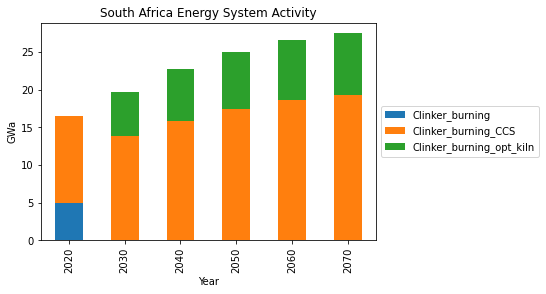

In [84]:
# Use Message reporter plot, not tutorial
# Trigger the calculation and plotting
rep_cement.set_filters(t = ['Clinker_burning', 'Clinker_burning_CCS', 'Clinker_burning_opt_kiln'])
prepare_plots(rep_cement)
rep_cement.get("plot activity")

In [85]:
# rep_cement = Reporter.from_scenario(scenario_pc)
# prepare_plots(rep_cement)
# #rep_cement.set_filters(t = ['syn_liq_ccs', 'ref_hil', 'loil_t_d', 'gas_t_d', 'gas_cc', 'elec_t_d', 'coal_extr', 'biomass_nc'])
# rep_cement.get("plot activity")

#### Baseline scenario

In [86]:
ACT_base = rep.full_key('ACT')
df_ACT_base = rep.get(ACT_base)

In [87]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['t']
    return df.drop(['t'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep.convert_pyam(
    # Quantity or quantities to convert
    quantities=ACT_base.drop('h', 'hd', 'm', 'nd', 'yv'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(nl="region", ya="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'ACT:iamc'

In [88]:
df_ACT_base = rep.get(new_key)

In [89]:
ACT_time_base = df_ACT_base.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
ACT_time_base

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,baseline,South Africa,bio_extr,,13.775125,19.474361,20.000000,20.000000,20.000000,20.000000
1,MESSAGEix South Africa,baseline,South Africa,bio_istig,,0.031849,0.011105,0.003872,0.001350,0.000471,0.000164
2,MESSAGEix South Africa,baseline,South Africa,biomass_i,,1.184057,1.700000,1.600000,1.500000,0.898105,0.537729
3,MESSAGEix South Africa,baseline,South Africa,biomass_nc,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,MESSAGEix South Africa,baseline,South Africa,biomass_rc,,3.948134,5.479913,4.960799,4.038440,2.666613,0.929790
...,...,...,...,...,...,...,...,...,...,...,...
71,MESSAGEix South Africa,baseline,South Africa,sp_el_I,,13.426834,17.763708,21.359564,23.858725,26.357885,28.857046
72,MESSAGEix South Africa,baseline,South Africa,sp_el_RC,,7.222510,12.424913,19.042704,26.599859,34.157013,41.714165
73,MESSAGEix South Africa,baseline,South Africa,syn_liq,,4.490273,2.688492,1.609699,0.963787,0.577055,0.345504
74,MESSAGEix South Africa,baseline,South Africa,syn_liq_ccs,,0.000000,1.257789,3.306595,6.643885,12.079978,20.934800


In [90]:
df_output = baseline.par('output')
electr_techs = df_output.loc[df_output.commodity == 'electr'].loc[df_output.level == 'secondary'].technology.unique()

In [91]:
df = ACT_time_base.loc[ACT_time_base.variable.isin(electr_techs)]
df

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
1,MESSAGEix South Africa,baseline,South Africa,bio_istig,,0.031849,0.011105,0.003872,0.001350,0.000471,0.000164
6,MESSAGEix South Africa,baseline,South Africa,coal_adv,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,MESSAGEix South Africa,baseline,South Africa,coal_adv_ccs,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,MESSAGEix South Africa,baseline,South Africa,coal_ppl,,24.807579,8.649868,3.016022,1.051622,0.366678,0.127853
20,MESSAGEix South Africa,baseline,South Africa,elec_imp,,1.491171,0.892819,0.534564,0.320063,0.191634,0.114738
26,MESSAGEix South Africa,baseline,South Africa,foil_ppl,,0.018801,0.006556,0.002286,0.000797,0.000278,0.000097
32,MESSAGEix South Africa,baseline,South Africa,gas_cc,,0.087786,0.030609,0.010673,0.003721,0.001298,0.000452
33,MESSAGEix South Africa,baseline,South Africa,gas_cc_ccs,,0.000000,0.067509,0.206592,0.275857,0.096185,0.033538
34,MESSAGEix South Africa,baseline,South Africa,gas_ct,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40,MESSAGEix South Africa,baseline,South Africa,gas_ppl,,0.029514,0.010291,0.003588,0.001251,0.000436,0.000152


In [92]:
#df.to_excel('electr_act_baseline_high_emission.xlsx')

#### Cement scenario

In [93]:
rep_cement = Reporter.from_scenario(scenario_pc)

In [94]:
ACT_cement = rep_cement.full_key('ACT')
df_ACT_cement = rep_cement.get(ACT_cement)

In [95]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['t']
    return df.drop(['t'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep_cement.convert_pyam(
    # Quantity or quantities to convert
    quantities=ACT_cement.drop('h', 'hd', 'm', 'nd', 'yv'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(nl="region", ya="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'ACT:iamc'

In [96]:
df_ACT_cement = rep_cement.get(new_key)

In [97]:
ACT_time_cement = df_ACT_cement.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
ACT_time_cement

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,cement added,South Africa,Cement_grinding,,20.709734,24.694648,28.391852,31.248572,33.201925,34.395332
1,MESSAGEix South Africa,cement added,South Africa,Clinker_burning,,4.970336,0.000000,0.000000,0.000000,0.000000,0.000000
2,MESSAGEix South Africa,cement added,South Africa,Clinker_burning_CCS,,11.597451,13.829003,15.899437,17.499200,18.593078,19.261386
3,MESSAGEix South Africa,cement added,South Africa,Clinker_burning_opt_kiln,,0.000000,5.926715,6.814044,7.499657,7.968462,8.254880
4,MESSAGEix South Africa,cement added,South Africa,Mining_clinker,,13.254230,15.804574,18.170785,19.999086,21.249232,22.013013
...,...,...,...,...,...,...,...,...,...,...,...
81,MESSAGEix South Africa,cement added,South Africa,sp_el_I,,13.426834,17.763708,21.359564,23.858725,26.357885,28.857046
82,MESSAGEix South Africa,cement added,South Africa,sp_el_RC,,7.222510,12.424913,19.042704,26.599859,34.157013,41.714165
83,MESSAGEix South Africa,cement added,South Africa,syn_liq,,4.490273,2.688492,1.609699,0.963787,0.577055,0.345504
84,MESSAGEix South Africa,cement added,South Africa,syn_liq_ccs,,0.000000,1.257789,3.306595,6.643885,12.079978,20.934800


In [98]:
df = ACT_time_cement.loc[ACT_time_cement.variable.isin(electr_techs)]
df

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
7,MESSAGEix South Africa,cement added,South Africa,bio_istig,,0.038927,0.013573,0.004733,0.001650,0.000575,0.000201
16,MESSAGEix South Africa,cement added,South Africa,coal_adv,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,MESSAGEix South Africa,cement added,South Africa,coal_adv_ccs,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,MESSAGEix South Africa,cement added,South Africa,coal_ppl,,24.807579,8.649868,3.016022,1.051622,0.366678,0.127853
30,MESSAGEix South Africa,cement added,South Africa,elec_imp,,1.491171,0.892819,0.534564,0.320063,0.191634,0.114738
36,MESSAGEix South Africa,cement added,South Africa,foil_ppl,,0.018801,0.006556,0.002286,0.000797,0.000278,0.000097
42,MESSAGEix South Africa,cement added,South Africa,gas_cc,,0.504609,0.175946,0.061349,0.021391,0.007459,0.002601
43,MESSAGEix South Africa,cement added,South Africa,gas_cc_ccs,,0.000000,0.000000,0.569079,2.017405,2.287610,0.797640
44,MESSAGEix South Africa,cement added,South Africa,gas_ct,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50,MESSAGEix South Africa,cement added,South Africa,gas_ppl,,0.083433,0.029091,0.010143,0.003537,0.001233,0.000430


In [99]:
#df.to_excel('electr_act_cement_high_emission.xlsx')

In [100]:
df_fuel = ACT_time_cement.loc[ACT_time_cement.variable.isin(fuel_for_clinker_technologies)]
df_fuel

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
12,MESSAGEix South Africa,cement added,South Africa,clinker_coal,,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
13,MESSAGEix South Africa,cement added,South Africa,clinker_fueloil,,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
14,MESSAGEix South Africa,cement added,South Africa,clinker_gas,,0.154749,1.357204,1.560401,1.717404,1.82476,1.890349
15,MESSAGEix South Africa,cement added,South Africa,clinker_lightoil,,1.793105,0.000000,0.000000,0.000000,0.00000,0.000000


In [101]:
#df_fuel.to_excel('fuel_activity_high_emission.xlsx')

### Plotting both

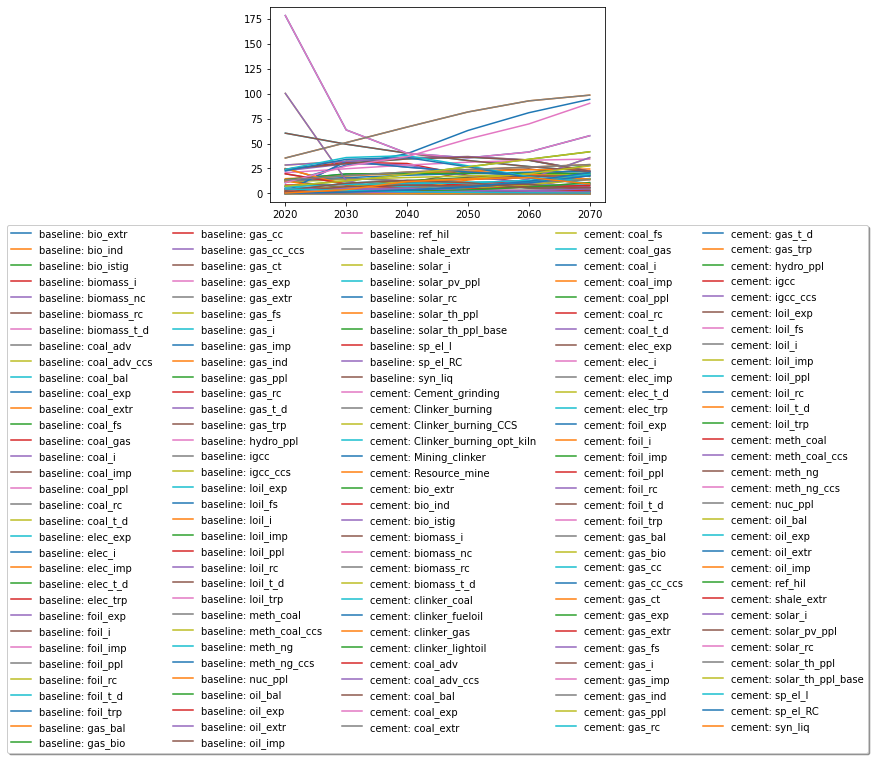

In [102]:
# Making an array with the years from the dataframe columns
YEARS = np.array(ACT_time_base.columns)[5:]

fig = plt.subplots()
ax = plt.subplot(111)

for act in range(len(ACT_time_base.values)):
    ax.plot(YEARS, ACT_time_base.values[:,5:][act], label = str('baseline: ' + df_ACT_base.variable[act]))
    
for act in range(len(ACT_time_cement.values)):
    ax.plot(YEARS, ACT_time_cement.values[:,5:][act], label = str('cement: ' + df_ACT_cement.variable[act]))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
          fancybox=True, shadow=True, ncol=5)

plt.show()

### EXT (Resource extraction)

#### Baseline scenario

In [103]:
# DEMAND_cement = rep_cement.full_key('DEMAND')
# df_DEMAND_cement = rep_cement.get(DEMAND_cement)
# df_DEMAND_cement

In [104]:
EXT_base = rep.full_key('EXT')
df_EXT_base = rep.get(EXT_base)

In [105]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['c']
    return df.drop(['c'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep.convert_pyam(
    # Quantity or quantities to convert
    quantities=EXT_base.drop('g'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'EXT:iamc'

In [106]:
df_EXT_base = rep.get(new_key)

In [107]:
EXT_time_base = df_EXT_base.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
EXT_time_base

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,baseline,South Africa,coal,,178.218915,63.597873,40.290854,35.582809,41.452840,57.794379
1,MESSAGEix South Africa,baseline,South Africa,crudeoil,,0.000000,0.000000,0.138130,0.082704,0.049518,0.029648
2,MESSAGEix South Africa,baseline,South Africa,gas,,0.000700,0.000419,0.028586,0.000150,0.000090,0.000054
3,MESSAGEix South Africa,baseline,South Africa,shalegas,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Cement scenario

In [108]:
EXT_cement = rep_cement.full_key('EXT')
df_EXT_cement = rep_cement.get(EXT_cement)

In [109]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['c']
    return df.drop(['c'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep_cement.convert_pyam(
    # Quantity or quantities to convert
    quantities=EXT_cement.drop('g'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'EXT:iamc'

In [110]:
df_EXT_cement = rep_cement.get(new_key)

In [111]:
EXT_time_cement = df_EXT_cement.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
EXT_time_cement

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,cement added,South Africa,coal,,178.314281,63.597873,40.290854,35.582809,41.45321,57.794379
1,MESSAGEix South Africa,cement added,South Africa,crudeoil,,0.000000,0.000000,0.000000,0.300000,0.00000,0.000000
2,MESSAGEix South Africa,cement added,South Africa,gas,,0.000700,0.000419,0.028586,0.000150,0.00009,0.000054
3,MESSAGEix South Africa,cement added,South Africa,shalegas,,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Price emissions

#### Baseline scenario

In [112]:
rep.get(rep.full_key('PRICE_EMISSION'))

n             type_emission  type_tec  y   
South Africa  CO2            all       2020     748.276590
                                       2030    1218.863726
                                       2040    1985.400588
                                       2050    3234.008372
                                       2060    5267.858897
                                       2070    8580.787114
Name: PRICE_EMISSION, dtype: float64

In [113]:
PRICE_EMISSION_base = rep.full_key('PRICE_EMISSION')
df_PRICE_EMISSION_base = rep.get(PRICE_EMISSION_base)
df_PRICE_EMISSION_base

n             type_emission  type_tec  y   
South Africa  CO2            all       2020     748.276590
                                       2030    1218.863726
                                       2040    1985.400588
                                       2050    3234.008372
                                       2060    5267.858897
                                       2070    8580.787114
Name: PRICE_EMISSION, dtype: float64

In [114]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['type_emission']
    return df.drop(['type_emission'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep.convert_pyam(
    # Quantity or quantities to convert
    quantities=PRICE_EMISSION_base.drop('type_tec'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'PRICE_EMISSION:iamc'

In [115]:
df_PRICE_EMISSION_base = rep.get(new_key)

In [116]:
df_PRICE_EMISSION_base

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGEix South Africa (1)
 * scenario : baseline (1)
Timeseries data coordinates:
   region   : South Africa (1)
   variable : CO2 (1)
   unit     : '' (1)
   year     : 2020, 2030, 2040, 2050, 2060, 2070 (6)
Meta indicators:
   exclude (bool) False (1)

In [117]:
PRICE_EMISSION_time_base = df_PRICE_EMISSION_base.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
PRICE_EMISSION_time_base

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,baseline,South Africa,CO2,,748.27659,1218.863726,1985.400588,3234.008372,5267.858897,8580.787114


#### Cement scenario

In [118]:
PRICE_EMISSION_cement = rep_cement.full_key('PRICE_EMISSION')
df_PRICE_EMISSION_cement = rep_cement.get(PRICE_EMISSION_cement)

In [119]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['type_emission']
    return df.drop(['type_emission'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep_cement.convert_pyam(
    # Quantity or quantities to convert
    quantities=PRICE_EMISSION_cement.drop('type_tec'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'PRICE_EMISSION:iamc'

In [120]:
df_PRICE_EMISSION_cement = rep_cement.get(new_key)

In [121]:
PRICE_EMISSION_time_cement = df_PRICE_EMISSION_cement.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
PRICE_EMISSION_time_cement

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,cement added,South Africa,CO2,,559.212429,910.898127,1483.757075,2416.883944,3936.849297,6412.712712


### Emissions

#### Base scenario

In [122]:
EMISS_base = rep.full_key('EMISS')
df_EMISS_base = rep.get(EMISS_base)

In [123]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['e']
    return df.drop(['e'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep.convert_pyam(
    # Quantity or quantities to convert
    quantities=EMISS_base.drop('type_tec'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'EMISS:iamc'

In [124]:
df_EMISS_base = rep.get(new_key)

In [125]:
EMISS_time_base = df_EMISS_base.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
EMISS_time_base

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,baseline,South Africa,CH4,,12.354796,4.522104,3.312308,2.460830,2.856014,3.972848
1,MESSAGEix South Africa,baseline,South Africa,CO2,,460.399920,236.940708,175.789617,146.582274,124.686736,97.600746
2,MESSAGEix South Africa,baseline,World,CH4,,12.354796,4.522104,3.312308,2.460830,2.856014,3.972848
3,MESSAGEix South Africa,baseline,World,CO2,,460.399920,236.940708,175.789617,146.582274,124.686736,97.600746


#### Cement scenario

In [126]:
EMISS_cement = rep_cement.full_key('EMISS')
df_EMISS_cement = rep_cement.get(EMISS_cement)

In [127]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['e']
    return df.drop(['e'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep_cement.convert_pyam(
    # Quantity or quantities to convert
    quantities=EMISS_cement.drop('type_tec'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'EMISS:iamc'

In [128]:
df_EMISS_cement = rep_cement.get(new_key)

In [129]:
EMISS_time_cement = df_EMISS_cement.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
EMISS_time_cement

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,cement added,South Africa,CH4,,12.350410,4.515230,3.251552,2.510786,2.844655,3.966032
1,MESSAGEix South Africa,cement added,South Africa,CO2,,459.879322,238.864318,177.856910,149.530115,127.891107,100.175035
2,MESSAGEix South Africa,cement added,World,CH4,,12.350410,4.515230,3.251552,2.510786,2.844655,3.966032
3,MESSAGEix South Africa,cement added,World,CO2,,459.879322,238.864318,177.856910,149.530115,127.891107,100.175035


### Plotting both

In [130]:
np.array(EMISS_time_cement.loc[EMISS_time_cement['region'] == 'South Africa'].loc[EMISS_time_cement['variable'] == 'CO2'].iloc[:,5:])

array([[459.87932151, 238.86431844, 177.85690979, 149.53011539,
        127.89110696, 100.17503537]])

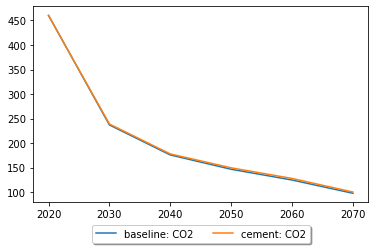

In [131]:
# Making an array with the years from the dataframe columns
YEARS = np.array(EMISS_time_cement.columns[5:])

x_base = np.array(EMISS_time_base.loc[EMISS_time_base['region'] == 'South Africa'].loc[EMISS_time_base['variable'] == 'CO2'].iloc[:,5:])
x_cement = np.array(EMISS_time_cement.loc[EMISS_time_cement['region'] == 'South Africa'].loc[EMISS_time_cement['variable'] == 'CO2'].iloc[:,5:])

fig = plt.subplots()
ax = plt.subplot(111)
# Divide by 2 to avoid also plotting "World"

for act in range(len(x_base)):
    plt.plot(YEARS, x_base[act], label = str('baseline: CO2'))
    # Divide by 2 to avoid also plotting "World"
for act in range(len(x_cement)):
    plt.plot(YEARS, x_cement[act], label = str('cement: CO2'))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
          fancybox=True, shadow=True, ncol=5)

plt.show()

### Commodity price

### Baseline

In [132]:
PRICE_COMMODITY_base = rep.full_key('PRICE_COMMODITY')
df_PRICE_COMMODITY_base = rep.get(PRICE_COMMODITY_base)

In [133]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['c'] + '|' + df['l'] 
    return df.drop(['c','l'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep.convert_pyam(
    # Quantity or quantities to convert
    quantities=PRICE_COMMODITY_base.drop('h'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'PRICE_COMMODITY:iamc'

In [134]:
df_PRICE_COMMODITY_base = rep.get(new_key)

In [135]:
PRICE_COMMODITY_time_base = df_PRICE_COMMODITY_base.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
PRICE_COMMODITY_time_base.head()

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,baseline,South Africa,biomass|final,,55.000000,60.000000,2915.394323,4502.856961,7272.655277,11903.837149
1,MESSAGEix South Africa,baseline,South Africa,biomass|primary,,50.000000,50.000000,2900.394323,4482.856961,7247.655277,11873.837149
2,MESSAGEix South Africa,baseline,South Africa,coal|final,,2791.341495,4257.610411,5624.876112,10078.989857,16382.098876,26648.989731
3,MESSAGEix South Africa,baseline,South Africa,coal|primary,,2355.640172,3813.849188,6189.299023,10058.989857,16362.098876,26628.989731
4,MESSAGEix South Africa,baseline,South Africa,coal|secondary,,2771.341495,4237.610411,5604.876112,10058.989857,16362.098876,26628.989731


### Cement

In [136]:
PRICE_COMMODITY_cement = rep_cement.full_key('PRICE_COMMODITY')
df_PRICE_COMMODITY_cement = rep_cement.get(PRICE_COMMODITY_cement)

In [137]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df):
    """Callback function to fill the IAMC 'variable' column."""
    df['variable'] = df['c'] + '|' + df['l'] 
    return df.drop(['c','l'], axis=1)

# Add node(s) that convert data to pyam.IamDataFrame objects
new_key = rep_cement.convert_pyam(
    # Quantity or quantities to convert
    quantities=PRICE_COMMODITY_cement.drop('h'),
    # Dimensions to use for the 'Region' and 'Year' IAMC columns
    rename=dict(n="region", y="year"),
    # Use this function to collapse the 'l', 't', and 'c' dimensions
    # into the 'Variable' IAMC column
    collapse=format_variable
)

new_key

'PRICE_COMMODITY:iamc'

In [138]:
df_PRICE_COMMODITY_cement = rep_cement.get(new_key)

In [139]:
PRICE_COMMODITY_time_cement = df_PRICE_COMMODITY_cement.filter(year = [2020, 2030, 2040, 2050, 2060, 2070]).timeseries().reset_index()
PRICE_COMMODITY_time_cement.head()

,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
0,MESSAGEix South Africa,cement added,South Africa,biomass|final,,55.000000,60.000000,2128.492305,3390.206225,5459.594011,8950.354855
1,MESSAGEix South Africa,cement added,South Africa,biomass|primary,,50.000000,50.000000,2113.492305,3370.206225,5434.594011,8920.354855
2,MESSAGEix South Africa,cement added,South Africa,cement|useful,,211.222111,341.410758,416.050039,516.284603,713.204553,1019.474535
3,MESSAGEix South Africa,cement added,South Africa,clinker_fuel|secondary,,NaN,1757.963100,2905.505163,4532.062828,7260.410090,11679.903114
4,MESSAGEix South Africa,cement added,South Africa,clinker|secondary,,264.027639,426.763448,520.062549,645.355754,891.505691,1274.343169


### Plotting both

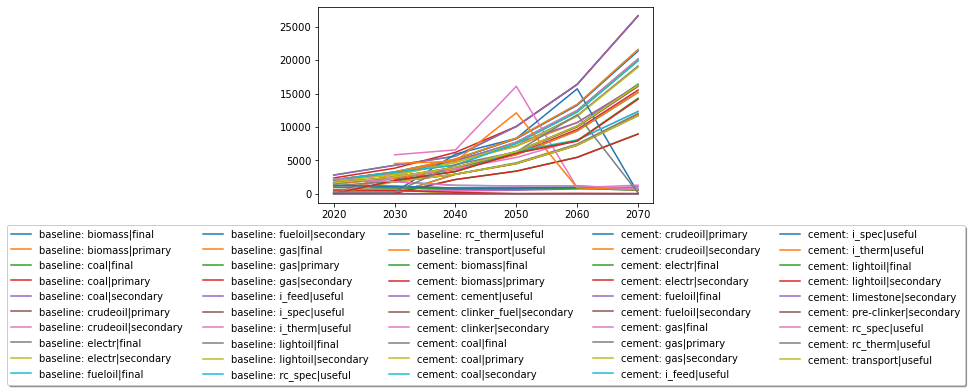

In [140]:
# Making an array with the years from the dataframe columns
YEARS = np.array(PRICE_COMMODITY_time_base.columns)[5:]

fig = plt.subplots()
ax = plt.subplot(111)

for act in range(len(PRICE_COMMODITY_time_base.values)):
    ax.plot(YEARS, PRICE_COMMODITY_time_base.values[:,5:][act], label = str('baseline: ' + df_PRICE_COMMODITY_base.variable[act]))
    
for act in range(len(PRICE_COMMODITY_time_cement.values)):
    ax.plot(YEARS, PRICE_COMMODITY_time_cement.values[:,5:][act], label = str('cement: ' + df_PRICE_COMMODITY_cement.variable[act]))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
          fancybox=True, shadow=True, ncol=5)

plt.show()

# Exporting to excel

#### Collecting all to one dataframe

In [141]:
#baseline.var_list()

In [142]:
def df_append_first(df1, df2, VAR):
    DF = df1.append(df2, ignore_index = True)
    DF.insert(0, 'VAR', VAR)
    return DF

In [143]:
variables_list = ['EXT', 'ACT', 'EMISS', 'PRICE_COMMODITY']#, 'PRICE_EMISSION']

In [144]:
df_base_list = [EXT_time_base, ACT_time_base, EMISS_time_base,
          PRICE_COMMODITY_time_base]#, PRICE_EMISSION_base]

In [145]:
df_cement_list = [EXT_time_cement, ACT_time_cement, EMISS_time_cement,
          PRICE_COMMODITY_time_cement]#, PRICE_EMISSION_cement]

In [146]:
final_dataframe = pd.DataFrame()
df_var = 0
for d1, d2, string in zip(df_base_list, df_cement_list, variables_list):
    df_var = df_append_first(d1, d2, string)
    final_dataframe = final_dataframe.append(df_var, ignore_index=True)
final_dataframe.tail()

C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\60305865.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF = df1.append(df2, ignore_index = True)
C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\679605978.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.append(df_var, ignore_index=True)
C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\60305865.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF = df1.append(df2, ignore_index = True)
C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\679605978.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.

,VAR,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
222,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,limestone|secondary,,4.940656e-324,4.940656e-324,4.940656e-324,4.940656e-324,4.940656e-324,4.940656e-324
223,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,pre-clinker|secondary,,1.511261e+00,1.360326e+00,1.022574e+00,1.064060e+00,1.262800e+00,7.026416e-01
224,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,rc_spec|useful,,2.247594e+03,1.789831e+03,1.256769e+03,1.150488e+03,1.180750e+03,6.911988e+02
225,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,rc_therm|useful,,2.332500e+02,2.298333e+02,4.354235e+03,6.262762e+03,1.182105e+04,1.125000e+02
226,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,transport|useful,,1.593963e+03,2.505024e+03,3.945866e+03,6.295166e+03,1.009072e+04,1.624206e+04


In [147]:
df_PRICE_EMISSION = PRICE_EMISSION_time_base #change between base or cement here
df_PRICE_EMISSION.insert(0, 'VAR', 'PRICE_EMISSION')
final_dataframe = final_dataframe.append(df_PRICE_EMISSION, ignore_index=True)

C:\Users\philipgj\AppData\Local\Temp\ipykernel_20080\1387730396.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.append(df_PRICE_EMISSION, ignore_index=True)


In [148]:
final_dataframe.tail()

,VAR,model,scenario,region,variable,unit,2020,2030,2040,2050,2060,2070
223,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,pre-clinker|secondary,,1.511261,1.360326,1.022574,1.064060,1.262800,0.702642
224,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,rc_spec|useful,,2247.593739,1789.831198,1256.768800,1150.488488,1180.749974,691.198789
225,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,rc_therm|useful,,233.249996,229.833344,4354.234614,6262.761504,11821.054641,112.500000
226,PRICE_COMMODITY,MESSAGEix South Africa,cement added,South Africa,transport|useful,,1593.963220,2505.023972,3945.866379,6295.165912,10090.717148,16242.060029
227,PRICE_EMISSION,MESSAGEix South Africa,baseline,South Africa,CO2,,748.276590,1218.863726,1985.400588,3234.008372,5267.858897,8580.787114


### Export of results to excel file

In [149]:
#final_dataframe.to_excel('message results - baseline and cement - lowest emission bounds.xlsx')

## Other commands

In [129]:
# close platform connection
mp.close_db()

In [73]:
#scenario_pc.to_excel("scenario_test_01-04.xlsx")

In [76]:
# list units defined on platform
#mp.units()

In [ ]:
# mp.add_unit('USD/kW')  

In [77]:
#scenario_pc.remove_solution()

In [164]:
#scenario.par('emission')

In [13]:
#mp.scenario_list()

In [ ]:
# # Print the names of all parameters that contain "emission"
# [name for name in base_scen.par_list() if "emission" in name]